<a href="https://colab.research.google.com/github/jfogarty/python-code-practice/blob/master/advanced_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Output Handling

In Colaboratory the output of each cell is hosted in a separate iframe sandbox with limited access to the global notebook environment. APIs are available to enable some Python to Javascript and Javascript to Python communications, these APIs are generally only available for outputs which have been executed in the current session.



### Viewing Notebooks

Colaboratory attempts to provide a rich viewing experience where all resources needed to view outputs are persisted in the notebook itself and can be used for later viewing when not connected to a kernel.

In cases where outputs require execution to work properly this should be communicated to the user.

## display.Javascript to execute JavaScript from Python

The Javascript is persisted in the outputs of the notebook document and will be executed when the document is reloaded.

In [1]:
import IPython
js_code = '''
document.querySelector("#output-area").appendChild(document.createTextNode("hello world!"));
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

## Evaluate a Javascript expression from Python with eval_js

Evaluates the Javascript expression within the context of the outputframe of the current cell.

This executes the Javascript as a blocking call from Python and returns the result of the expression.

If the Javascript expression results in a [Promise](https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Global_Objects/Promise) then the call will block until the promise has settled and use the resulting value.

**Note:** This differs from `display.Javascript` in that the Javascript expression is not persisted in the notebook document and will not be executed when the document is reloaded.


In [2]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  window.someValue = new Promise(resolve => {
    setTimeout(() => {
      resolve("hello world!");
    }, 100);
  });
'''))


value = output.eval_js('someValue');
value

<IPython.core.display.Javascript object>

'hello world!'

## Javascript to Python communication

Python code can register callbacks which can be invoked by Javascript in the outputframe.

**Note:** This is only available to 'trusted' outputs- outputs which have been executed within the current session.

In [0]:
import IPython
from google.colab import output

def Concat(a, b):
  # Use display.JSON to transfer a structured result.
  return IPython.display.JSON({'result': ' '.join((a, b))})

output.register_callback('notebook.Concat', Concat)

In [4]:
%%javascript
(async function() {
  const result = await google.colab.kernel.invokeFunction(
    'notebook.Concat', // The callback name.
    ['hello', 'world!'], // The arguments.
    {}); // kwargs
  const text = result.data['application/json'];
  document.querySelector("#output-area").appendChild(document.createTextNode(text.result));
})();

<IPython.core.display.Javascript object>

### Persisting Updates

Since `invokeFunction` is only available for outputs which have executed within the current session
then it may be desirable to update the notebook so the changes take effect on notebook reload. An example
of doing this.

In [5]:
import IPython
from google.colab import output

display(IPython.display.HTML('''
    The items:
    <br><ol id="items"></ol>
    <button id='button'>Click to add</button>
    <script>
      document.querySelector('#button').onclick = () => {
        google.colab.kernel.invokeFunction('notebook.AddListItem', [], {});
      };
    </script>
    '''))

def add_list_item():
  # Use redirect_to_element to direct the elements which are being written.
  with output.redirect_to_element('#items'):
    # Use display to add items which will be persisted on notebook reload.
    display(IPython.display.HTML('<li> Another item</li>'))

output.register_callback('notebook.AddListItem', add_list_item)

### Using register_callback to make a button invoke a function

In [6]:
import IPython
import uuid
from google.colab import output

class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    callback_id = 'button-' + str(uuid.uuid4())
    output.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

def do_something():
  print('here')

InvokeButton('click me', do_something)

## Tagged Outputs

Output tagging is useful for removing or replacing chunks of outputs from Python.

In [7]:
import time
import sys
from google.colab import output

print('Starting.')

with output.use_tags('some_outputs'):
  sys.stdout.write('working....\n')
  sys.stdout.flush();
  time.sleep(2)

  sys.stdout.write('still working...\n')
  sys.stdout.flush();
  time.sleep(2)

# Now clear the previous outputs.
output.clear(output_tags='some_outputs')
print('All done!')


Starting.
All done!


## Pausing output processing

If your Javascript code is doing an asynchronous operation (such as loading other resources), use `colab.output.pauseOutputUntil` to pause execution of subsequent output messages until the promise has completed.

This has an additional benefit that when the notebook is later loaded then output will wait for all messages and pauses to complete before resizing the cell, reducing the amount of jank when loading notebooks.

In [8]:
import IPython

display(IPython.display.Javascript('''
  const promise = new Promise((resolve, reject) => {
    const script = document.createElement('script');
    script.src = 'data:,window.value = "hello world!"';
    script.onload = resolve;
    script.onerror = reject;
    document.head.appendChild(script);
  });
  // Pause subsequent outputs until the script has been loaded.
  google.colab.output.pauseOutputUntil(promise);
'''))

display(IPython.display.Javascript('''
    // Can immediately reference scripts loaded earlier since
    // output processing was blocked on them.
    document.body.appendChild(document.createTextNode(window.value));
'''))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Serving resources

Outputs in the browser can request resources from the kernel by requesting `https://localhost:{port}`. The protocol will automatically be translated from `https` to `http` and the `localhost` will be the kernel executing the code.

By default the responses to any kernel requests will be cached in the notebook JSON to make them available to viewers not connected to the kernel. To skip the caching of resources, set the HTTP header `x-colab-notebook-cache-control: no-cache` to any responses. See the 'Custom server' example below.

Outputs can only request resources from the kernel if they have been executed in the current session, when viewed the outputs will only have access to the cached responses.

### Jupyter nbextensions
Jupyter's nbextensions is a mechanism to bundle resources into Python libraries, see the [documentation](http://testnb.readthedocs.io/en/latest/examples/Notebook/Distributing%20Jupyter%20Extensions%20as%20Python%20Packages.html#Defining-the-server-extension-and-nbextension) for details.

An example of referencing these resources from outputs:

In [9]:
%%html
<link rel="stylesheet" href="/nbextensions/google.colab/tabbar.css">
<div class='goog-tab'>
  Some content
</div>

### Custom server

A webserver can be started on the kernel to serve up arbitrary resources.

The client needs to reference the resource with `https://localhost:{port}` but this will automatically be translated to `http://localhost:{port}`.

By default responses will be cached in the notebook for offline access.

In [10]:
import portpicker
import threading
import socket
import IPython

from six.moves import socketserver
from six.moves import SimpleHTTPServer

class V6Server(socketserver.TCPServer):
  address_family = socket.AF_INET6

class Handler(SimpleHTTPServer.SimpleHTTPRequestHandler):
  def do_GET(self):
    self.send_response(200)
    # If the response should not be cached in the notebook for
    # offline access:
    # self.send_header('x-colab-notebook-cache-control', 'no-cache')
    self.end_headers()
    self.wfile.write(b'''
      document.querySelector('#output-area').appendChild(document.createTextNode('Script result!'));
    ''')

port = portpicker.pick_unused_port()

def server_entry():
    httpd = V6Server(('::', port), Handler)
    # Handle a single request then exit the thread.
    httpd.serve_forever()

thread = threading.Thread(target=server_entry)
thread.start()

# Display some HTML referencing the resource.
display(IPython.display.HTML('<script src="https://localhost:{port}/"></script>'.format(port=port)))

## Cross-output communication

The output of each cell is hosted in a separate sandboxed iframe without direct access to the contents of other cells, but they can create [BroadcastChannel](https://developer.mozilla.org/en-US/docs/Web/API/BroadcastChannel/BroadcastChannel)s to communicate between cells.

In [11]:
%%javascript
const listenerChannel = new BroadcastChannel('channel');
listenerChannel.onmessage = (msg) => {
  const div = document.createElement('div');
  div.textContent = msg.data;
  document.body.appendChild(div);
};

<IPython.core.display.Javascript object>

This second cell will be in a separate sandboxed iframe.


In [12]:
%%javascript
const senderChannel = new BroadcastChannel('channel');
senderChannel.postMessage('Hello world!');

<IPython.core.display.Javascript object>

## Rendering SymPy in Colab

Rendering [SymPy](http://www.sympy.org) equations in Colab requires the MathJax javascript library to be available within each cell output. The following defines an execution hook that loads it automatically each time you execute a cell.

In [15]:
from IPython.display import Math, HTML

def load_mathjax_in_cell_output():
  display(HTML("<script src='https://www.gstatic.com/external_hosted/"
               "mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register('pre_run_cell', load_mathjax_in_cell_output)

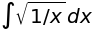

In [16]:
# try it out:
import sympy
sympy.init_printing()
x = sympy.symbols('x')
sympy.Integral(sympy.sqrt(1 / x), x)

## Camera Capture
Using a webcam to capture images for processing on the runtime.

In [17]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


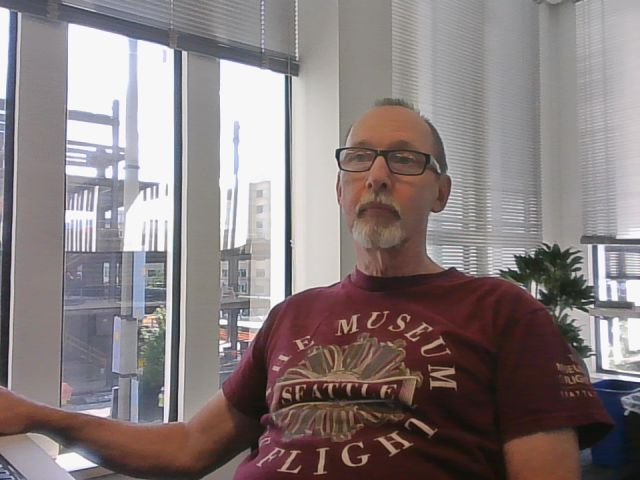

In [18]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Showing CV2 Images

The ``cv2.imshow()`` and ``cv.imshow()`` functions from the [opencv-python](https://github.com/skvark/opencv-python) package are incompatible with Jupyter notebook; see https://github.com/jupyter/notebook/issues/3935.

As a replacement, you can use the following function:

In [19]:
from google.colab.patches import cv2_imshow

For example, here we download and display a PNG image of the Colab logo:

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0  30054      0 --:--:-- --:--:-- --:--:-- 30054


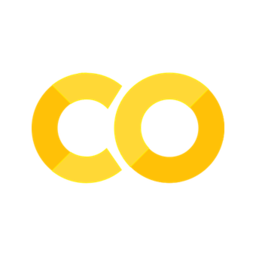

In [20]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)